# setup

In [1]:
import os

if os.getcwd().split('\\')[-1] == 'notebooks':
    os.chdir('..')

In [2]:
import pathlib
import matplotlib.pyplot as plt
import lasio
import numpy as np
# import tensorflow as tf
import pandas as pd
import math

from scipy import signal
from segysak.segy import get_segy_texthead, segy_header_scan, segy_header_scrape, segy_loader
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from scipy.linalg import toeplitz
from numpy.linalg import lstsq

# utils

In [3]:
def RC_fwd_model_ia(ia1, ia2):
    Rpp = (ia2 - ia1) / (ia2 + ia1)
    return Rpp

In [4]:
#Ordem de inputs da funcao: 1 - profundidade, 2- curva de poco que deseja filtrar parta a escala sismica, 3 -dado sismico 3D
#4- ponto mais raso em profundidade (equivalente ao corte inicial do dado sismico),
#5- ponto mais profundo(equivalente ao corte final do dado sismico)
def escala_sismica(depth,curva_poco,dado_sismico,depth_point1,depth_point2): 
    wells=[]
    
    wells.append(np.array([depth,curva_poco]).T)
    #print(wells)
    npocos = 1
    avgParam = 1 #parameter used for
    upperLimit = depth_point2#intersection of points
    lowerLimit = depth_point1
    columns = [] 
    jumpvec =[]
    inivec = np.zeros(npocos)
    endvec = np.zeros(npocos)
    dzi = np.zeros(npocos)
    indw = 0
    
    for well in wells:
        depthX = 0
        dzi[indw] = well[3,0] -well[2,0]
        ini, end = -1, -1
        for i in range(well.shape[0]):
            if well[i, 0] >= lowerLimit and well[i, 0] <= upperLimit:
                depthX += 1
                if ini == -1:
                    ini = i
            elif ini != -1:
                end = i-1
                break
        if end == -1:# in case is the whole well
            end = well.shape[0]-1
        jump = (depthX-1)/(dado_sismico.shape[2])
        
        inivec[indw] = ini
        endvec[indw] = end
        indw +=1
    
        jumpvec.append([math.floor(jump)])
        columns.append([math.floor(ini + j*jump) for j in range(dado_sismico.shape[2]+1)])
    
    jumpvec =np.array(jumpvec)

    wellsF =[]
    for i in range(len(wells)):
        auxWell = []
        #print(np.shape(inivec))
    
        # cria dados de poco com filtro
        auxWellF = []
    
        a = math.floor(inivec[i])

        #vetores com dados originais do poco selecionados na faixa de 200m
        auxcurva = wells[i][math.floor(inivec[i]):math.floor(endvec[i]),1]
        
        # escala dos dados sismicos em metros
        lb = 5
        #escala do poco i e'  dada por   (200/(endvec[i] - inivec[i]))
        ep =(200/(endvec[i] - inivec[i]))

        Timepoco  = np.arange(np.shape(auxcurva)[0])

        vpmedio = 4.865042027693202 #km/s
        dti = 2 * dzi[i]  / (1000 * vpmedio)   # dzi[i]  passo de profundidade poco poco i em metros
        Timepoco = Timepoco * dti
        nfiltp  = 3
        #60 na linha abaixo  corresponde 60 Hertz que define o corte no filtro (frequencias acima de 60 são cortadas)
        cutofffrp =  2 * 60 * dti
        #print(dti,cutofffrp)
        bp, ap = signal.butter(nfiltp, cutofffrp)
        curvafilt = signal.filtfilt(bp, ap, np.squeeze(auxcurva))
        
        for j in range((dado_sismico.shape[2])):

            curvaiF = curvafilt[j*jumpvec[i]]

            auxWellF.append([curvaiF])
        
        j = (dado_sismico.shape[2]) 
        curvaiF = curvafilt[j*jumpvec[i]-1]
        auxWellF.append([curvaiF])
    
        wellsF.append(auxWellF)

        wellsF[i] = np.array(auxWellF)

    wells = np.array(wellsF)
    return wells[0,:,0,0]

# poço

In [5]:
def porosity_calc(rho_b, rho_ma, rho_f):
    rho_n = np.array(rho_b)
    phi_calc = np.zeros(rho_n.size)
    for i in range(rho_n.size):
        phi_calc[i] = ((rho_n[i] - rho_ma) / (rho_f-rho_ma))*100

    return phi_calc

In [6]:
# well1 = lasio.read('7buz12rjs_editadas.las')
# well2 = lasio.read('7-buz-14da-rjs_curvas_basicas.las')
well3 = lasio.read('data/dados/7buz23rjs.las')
# well4 = lasio.read('7-buz-25-rjs_curvas_basicas.las')
well5 = lasio.read('data/dados/7-buz-29-rjs.las')
# well6 = lasio.read('7-buz-31d-rjs_curvas_basicas.las')
# well7 = lasio.read('8-BUZ-21D-RJS_editadas.las')
well8 = lasio.read('data/dados/8-buz-26-rjs.las')
well9 = lasio.read('data/dados/8buz28da.las')
# well10 = lasio.read('8-buz-32da-rjs_curvas_basicas.las')
# well11 = lasio.read('8buz15rjs_edit.las')
well12 = lasio.read('data/dados/8buz20rjs.las')
# well13 = lasio.read('3-BRSA-1184-RJS-las.las')
well14 = lasio.read('data/dados/7-buz-10-rjs.las')
# well15 = lasio.read('7-BUZ-30-RJS-las.las')
# well16 = lasio.read('8-BUZ-9-RJS-las.las')
# well20 = lasio.read('9-BRSA-1191-RJS-las.las') #converter nphi para porcentagem
# well18 = lasio.read('9-BUZ-4-RJS-las.las')
# well19 = lasio.read('9-BUZ-8-RJS-las.las')

##
# well17 = lasio.read('9-BRSA-1197-RJS-las.las') #Utilizar para gerar figura, converter nphi para porcentagem
well18 = lasio.read('data/dados/3-brsa-1053-rjs.las')

In [7]:
well3_df = well3.df().dropna(how = 'any', axis=0)
well5_df = well5.df().dropna(how = 'any', axis=0)
well8_df = well8.df().dropna(how = 'any', axis=0)
well9_df = well9.df().dropna(how = 'any', axis=0)
well12_df = well12.df().dropna(how = 'any', axis=0)
well14_df = well14.df().dropna(how = 'any', axis=0)
well18_df = well18.df().dropna(how = 'any', axis=0)

In [8]:
data3 = well3_df
res3 = np.array(data3['BRRESP'])[+150:]
rho3 = np.array(data3['BRDENS'])[+150:]
dtp3 = np.array(data3['BRDTP'])[+150:]
dts3 = np.array(data3['BRDTS'])[+150:]
phi3 = np.array(data3['BRNEUT'])[+150:]
gr3 = np.array(data3['BRGR'])[+150:]
z3 = data3.index[+150:]

vp3 = (10**3/dtp3)*0.3048 #km/s
vs3 = (10**3/dts3)*0.3048 #km/s

phi_den3 = porosity_calc(rho3,2.8,1.05)

twt3 = np.array(data3['TWT'])[+150:]
dpt3 = np.array(data3['DEPT'])[+150:]

In [9]:
data5 = well5_df
# res5 = np.array(data5['BRRESP'])[+150:]
res5 = np.array(data5['BRRESP'])
rho5 = np.array(data5['BRDENS']) #g/cm3
dtp5 = np.array(data5['BRDTP'])
phi5 = np.array(data5['BRNEUT'])
gr5 = np.array(data5['BRGR'])
z5 = data5.first_valid_index

vp5 = (10**3/dtp5)*0.3048 #km/s

phi_den5 = porosity_calc(rho5,2.8,1.05)

twt5 = np.array(data5['TWT'])
# dpt5 = np.array(data5['DEPT'])[+150:]
dpt5 = np.array(data5['TVD'])

In [10]:
data8 = well8_df
res8 = np.array(data8['BRRESP'])[+14200:]
rho8 = np.array(data8['BRDENS'])[+14200:]
dtp8 = np.array(data8['BRDTP'])[+14200:]
phi8 = np.array(data8['BRNEUT'])[+14200:]
gr8 = np.array(data8['BRGR'])[+14200:]
z8 = data8.index[+14200:]

vp8 = (10**3/dtp8)*0.3048 #km/s

phi_den8 = porosity_calc(rho8,2.8,1.05)

twt8 = np.array(data8['TWT'])[+14200:]

In [11]:
data9 = well9_df
res9 = np.array(data9['BRRESP'])
rho9 = np.array(data9['BRDENS'])
dtp9 = np.array(data9['BRDTP'])
phi9 = np.array(data9['BRNEUT'])
gr9 = np.array(data9['BRGR'])
z9 = data9.index

vp9 = (10**3/dtp9)*0.3048 #km/s

phi_den9 = porosity_calc(rho9,2.8,1.05)

twt9 = np.array(data9['TWT'])

In [12]:
data12 = well12_df
res12 = np.array(data12['BRRESP'])
rho12 = np.array(data12['BRDENS'])
dtp12 = np.array(data12['BRDTP'])
phi12 = np.array(data12['BRNEUT'])
gr12 = np.array(data12['BRGR'])
z12 = data12.index

vp12 = (10**3/dtp12)*0.3048 #km/s

phi_den12 = porosity_calc(rho12,2.8,1.05)

twt12 = np.array(data12['TWT'])

In [13]:
data14 = well14_df
# res14 = np.array(data14['RT90'])[+500:-500]
# rho14 = np.array(data14['RHOB'])[+500:-500]
# dtp14 = np.array(data14['DT'])[+500:-500]
# phi14 = np.array(data14['NPHI'])[+500:-500]
# gr14 = np.array(data14['GR'])[+500:-500]
# z14 = data14.index[+500:-500]
res14 = np.array(data14['RT90'])
rho14 = np.array(data14['RHOB'])
dtp14 = np.array(data14['DT'])
phi14 = np.array(data14['NPHI'])
gr14 = np.array(data14['GR'])
z14 = data14.index

vp14 = (10**3/dtp14)*0.3048 #km/s

phi_den14 = porosity_calc(rho14,2.8,1.05)

twt14 = np.array(data14['TWT'])

In [14]:
data18 = well18_df
res18 = np.array(data18['BRRESP'])
rho18 = np.array(data18['BRDENS'])
dtp18 = np.array(data18['BRDTP'])
phi18 = np.array(data18['BRNEUT'])*1e2
gr18 = np.array(data18['BRGR'])
z18 = data18.index

vp18 = (10**3/dtp18)*0.3048 #km/s

phi_den18 = porosity_calc(rho18,2.8,1.05)

twt18 = np.array(data18['TWT'])

# sismica

In [15]:
V3D_path = pathlib.Path("data/buzios_corte_tempo_ext.sgy")
# V3D_path = pathlib.Path("../datasets/ffb/Area_Teste_Interpretabilidade_10-04-24.sgy")
print("3D", V3D_path, V3D_path.exists())

3D data\buzios_corte_tempo_ext.sgy True


In [16]:
V3D = segy_loader(V3D_path, iline=189, xline=193, vert_domain="TWT")
V3D

C:\Users\katri\AppData\Local\Temp\ipykernel_4364\2357896217.py:1: DeprecationWarning: segy_loader will be removed in v0.6, please use the Xarray engine ds = xr.open_dataset(segy_file) method instead.
  V3D = segy_loader(V3D_path, iline=189, xline=193, vert_domain="TWT")
Processing Chunks:   0%|          | 0.00/1.00 [00:00<?, ? trace-chunks/s]


Loading as 3D
Fast direction is CROSSLINE_3D


Converting SEGY: 100%|██████████| 69.7k/69.7k [00:20<00:00, 3.32k traces/s]


<xarray.Dataset> Size: 14MB
Dimensions:  (iline: 176, xline: 399, twt: 49)
Coordinates:
  * iline    (iline) int16 352B 4000 4001 4002 4003 4004 ... 4172 4173 4174 4175
  * xline    (xline) int16 798B 2200 2201 2202 2203 2204 ... 2597 2598 2599 2600
  * twt      (twt) float64 392B 4.898e+03 4.902e+03 ... 5.086e+03 5.09e+03
Data variables:
    data     (iline, xline, twt) float32 14MB -0.1251 -0.5392 ... -0.4634
Attributes: (12/17)
    ns:                  None
    sample_rate:         4.0
    text:                C 1 3D VOLUME                                       ...
    measurement_system:  0
    d3_domain:           None
    epsg:                None
    ...                  ...
    percentiles:         [np.float64(-1.7228748907486933), np.float64(-1.7163...
    coord_scalar:        -10.0
    coord_scaled:        None
    dimensions:          None
    vert_dimension:      None
    vert_domain:         None

In [17]:
coord3 = [4131, 2572]
coord5 = [4075, 2472]
coord8 = [4102, 2360]
coord9 = [4070, 2155]
coord12 = [4168, 2525]
coord14 = [4065, 2492]
coord18 = [4114, 2500]

In [18]:
sismica3 = V3D.data.sel(iline = 4131, xline = 2572).data
sismica5 = V3D.data.sel(iline = 4075, xline = 2472).data
sismica8 = V3D.data.sel(iline = 4102, xline = 2360).data
# sismica9 = V3D.data.sel(iline = 4070, xline = 2155).data
sismica12 = V3D.data.sel(iline = 4168, xline = 2525).data
sismica14 = V3D.data.sel(iline = 4065, xline = 2492).data
sismica18 = V3D.data.sel(iline = 4114, xline = 2500).data

# wavelet

(26,)

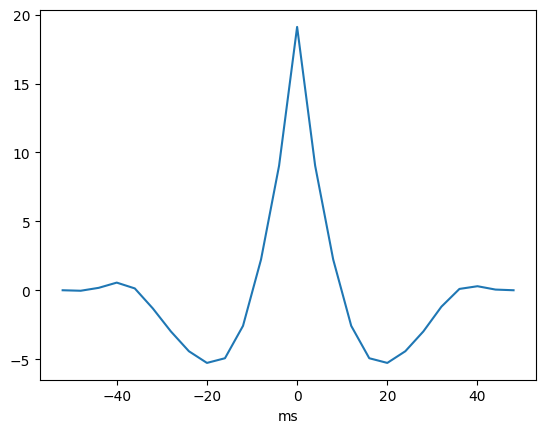

In [19]:
df_100_20_Z_4898_5092 = pd.read_csv('data/wav_100_20_Z_4898_5092.dat', 
                           header = None, sep = '\t')
wav_100_20_Z_4898_5092 = df_100_20_Z_4898_5092[1].values
plt.plot(df_100_20_Z_4898_5092[0].values, wav_100_20_Z_4898_5092); plt.xlabel('ms');
wav_100_20_Z_4898_5092.shape

# inversao

In [20]:
depth_point1 = 4898
depth_point2 = 5092

depth_point1true = 4948
depth_point2true = 5040

## well 3 7buz23rjs

## well 5 7-buz-29-rjs

In [21]:
idx5 = (twt5 > depth_point1) * (twt5 < depth_point2)
imp5 = vp5 * rho5 # km g/s/cm3 -> 10^3 m g / s / 10^-6 m3 = 10^9 g/s m2
imp5 = imp5[idx5]

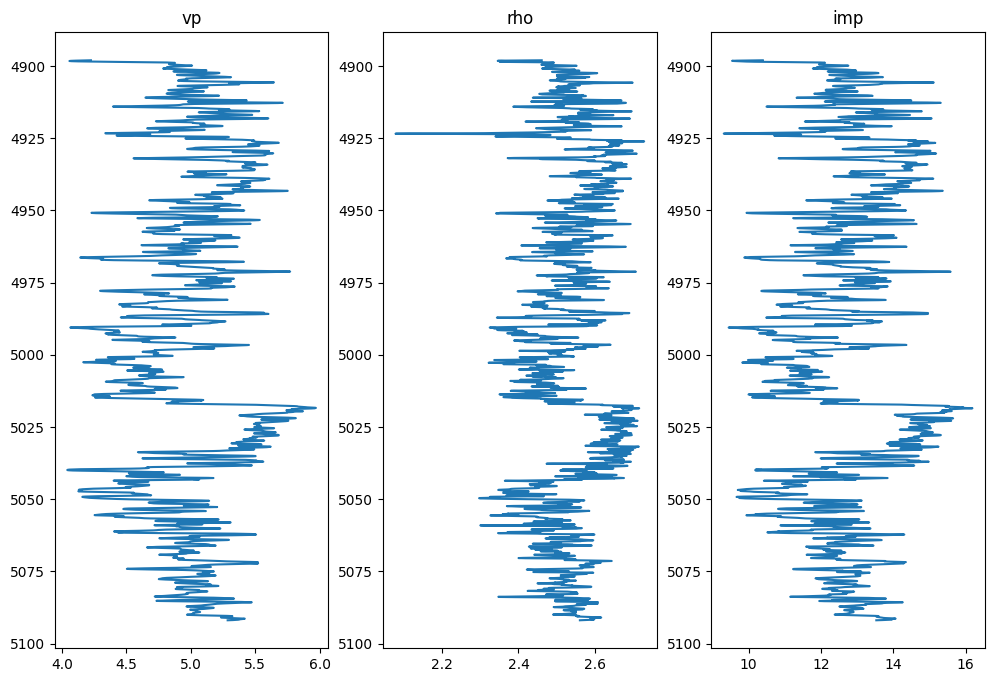

In [22]:
fig, axes = plt.subplots(1, 3, figsize = (12, 8))
zz = np.linspace(depth_point1, depth_point2, len(imp5) + 1)
axes[0].plot(vp5[idx5], zz[:-1]);
axes[0].invert_yaxis();
axes[0].set_title('vp');
axes[1].plot(rho5[idx5], zz[:-1]);
axes[1].invert_yaxis();
axes[1].set_title('rho');
axes[2].plot(imp5, zz[:-1]);
axes[2].invert_yaxis();
axes[2].set_title('imp');

In [23]:
Rpp5 = RC_fwd_model_ia(imp5[:-1], imp5[1:])
Rpplast5 = 0.0 / imp5[0]
Rpp5 = np.concatenate([Rpp5, np.expand_dims(Rpplast5, axis = 0)], axis = 0)

synth5 = np.convolve(wav_100_20_Z_4898_5092, Rpp5, mode = 'same')

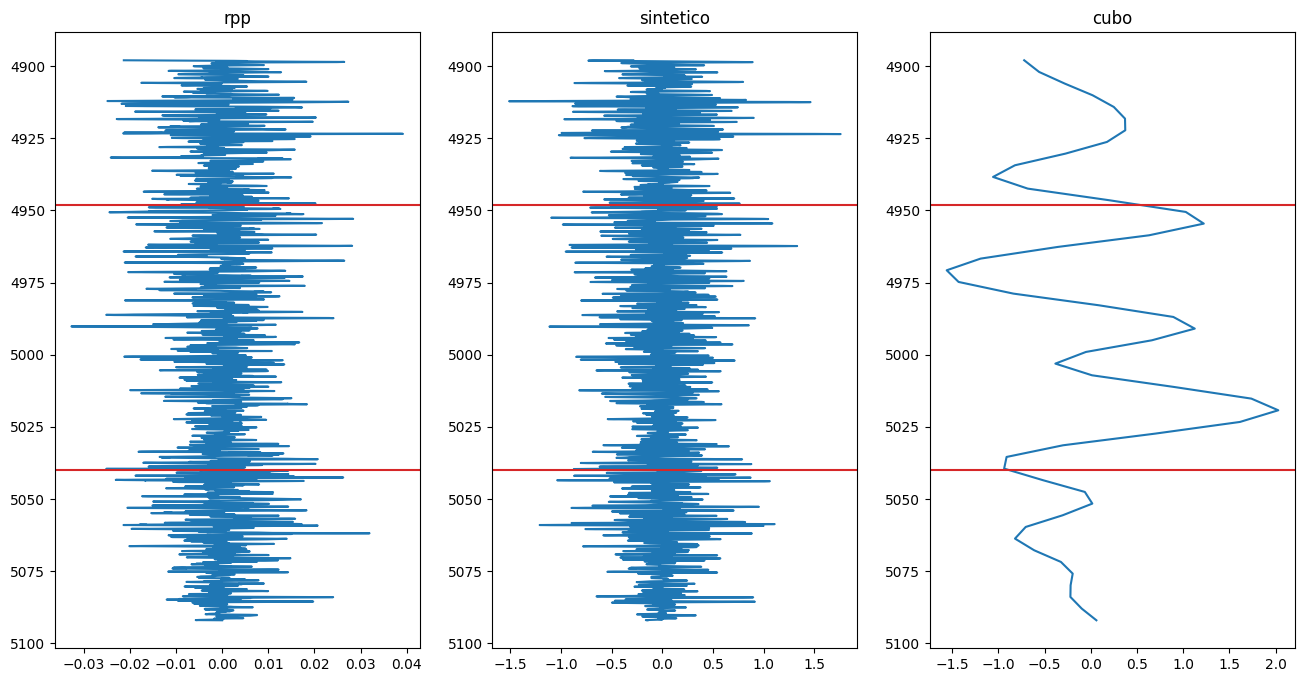

In [24]:
# dpt_point1 = dpt5[idx5][0]
# dpt_point2 = dpt5[idx5][-1]

# csv5 = (seis5['TVDSS (m)'] > dpt_point1) * (seis5['TVDSS (m)'] < dpt_point2)
fig, axes = plt.subplots(1, 3, figsize = (16, 8))
zz = np.linspace(depth_point1, depth_point2, len(Rpp5))
axes[0].plot(Rpp5, zz);
axes[0].invert_yaxis();
axes[0].set_title('rpp');
zz = np.linspace(depth_point1, depth_point2, synth5.shape[0])
axes[1].plot(synth5, zz);
axes[1].invert_yaxis();
axes[1].set_title('sintetico');
zz = np.linspace(depth_point1, depth_point2, len(sismica5))
axes[2].plot(sismica5, zz);
axes[2].invert_yaxis();
axes[2].set_title('cubo');

[axes[i].axhline(y = depth_point1true, color = 'tab:red') for i in range(3)];
[axes[i].axhline(y = depth_point2true, color = 'tab:red') for i in range(3)];
# zz = np.linspace(depth_point1, depth_point2, sum(csv5) + 1)
# axes[3].plot(seis5['Value'].loc[csv5].values, zz[:-1]);
# axes[3].invert_yaxis();
# axes[3].set_title('poço');

### low seis

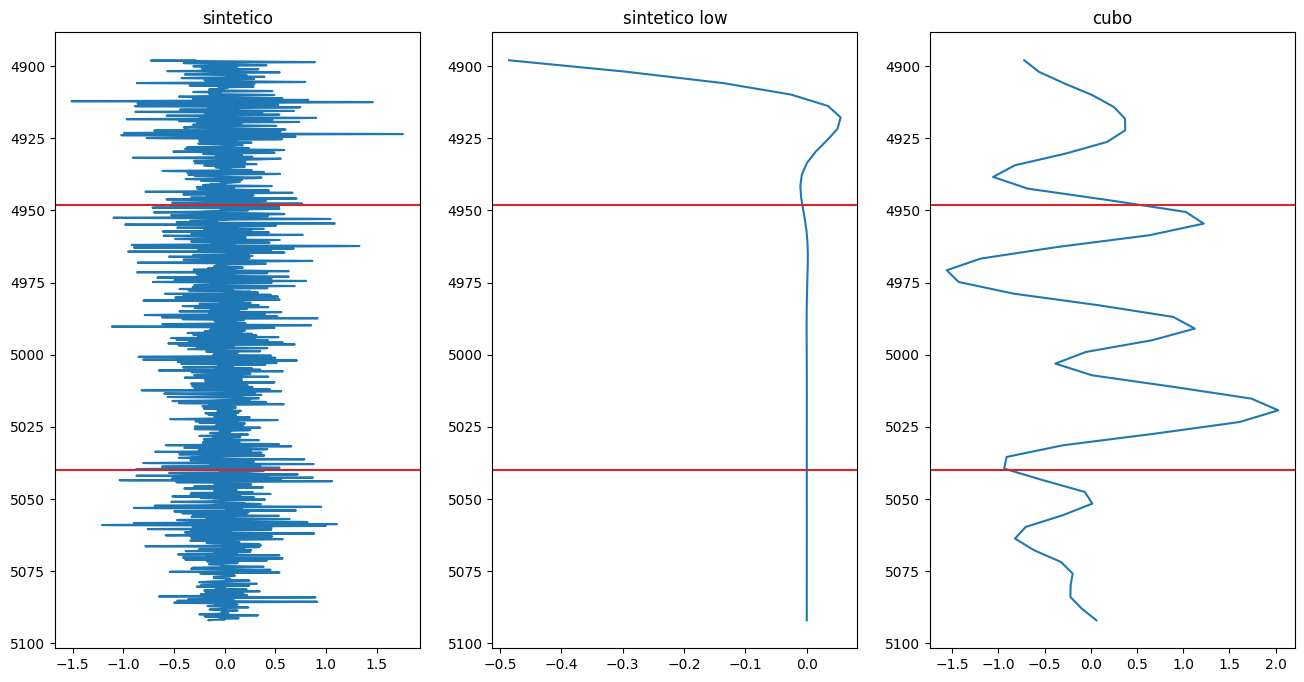

In [25]:
synth5low = escala_sismica(twt5[idx5], synth5, np.array(V3D.data), depth_point1, depth_point2)

fig, axes = plt.subplots(1, 3, figsize = (16, 8))

zz = np.linspace(depth_point1, depth_point2, len(synth5))
axes[0].plot(synth5, zz);
axes[0].invert_yaxis();
axes[0].set_title('sintetico');
zz = np.linspace(depth_point1, depth_point2, synth5low.shape[0])
axes[1].plot(synth5low, zz);
axes[1].invert_yaxis();
axes[1].set_title('sintetico low');
# axes[1].set_xlim([-0.01, 0.01]);
zz = np.linspace(depth_point1, depth_point2, len(sismica5))
axes[2].plot(sismica5, zz);
axes[2].invert_yaxis();
axes[2].set_title('cubo');

[axes[i].axhline(y = depth_point1true, color = 'tab:red') for i in range(3)];
[axes[i].axhline(y = depth_point2true, color = 'tab:red') for i in range(3)];

### low rpp

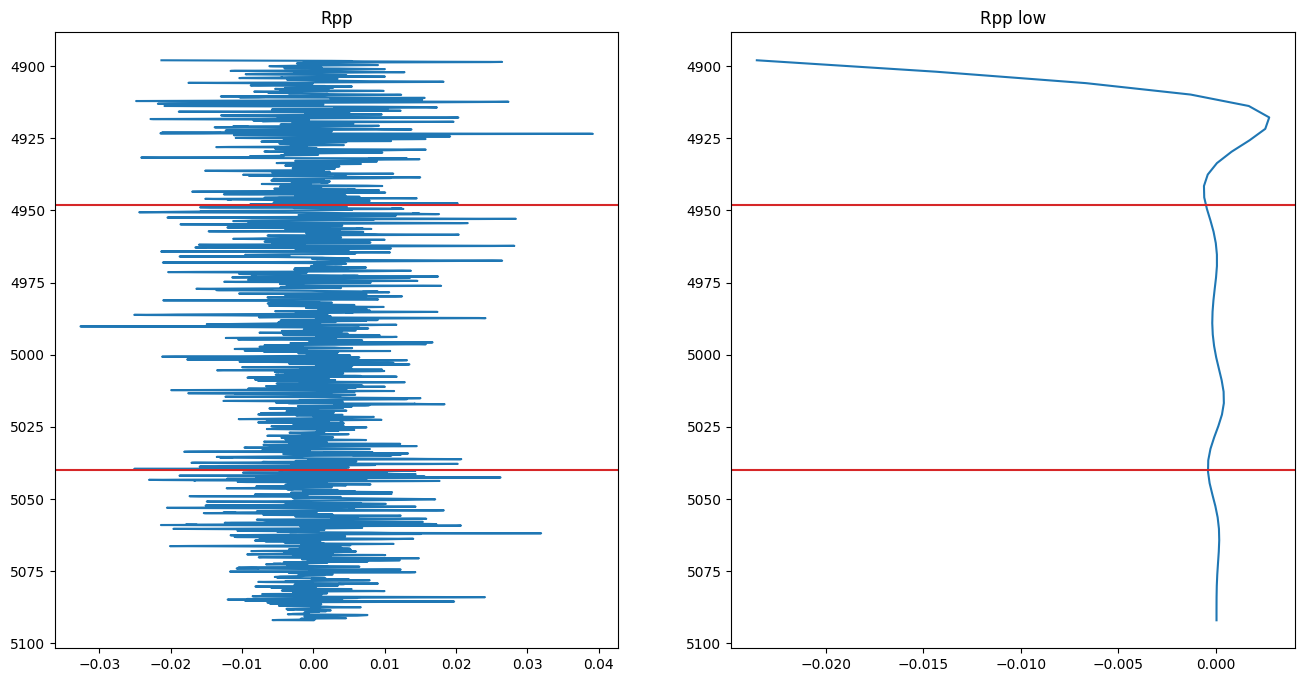

In [26]:
Rpp5low = escala_sismica(twt5[idx5], Rpp5, np.array(V3D.data), depth_point1, depth_point2)

fig, axes = plt.subplots(1, 2, figsize = (16, 8))

zz = np.linspace(depth_point1, depth_point2, len(Rpp5))
axes[0].plot(Rpp5, zz);
axes[0].invert_yaxis();
axes[0].set_title('Rpp');
zz = np.linspace(depth_point1, depth_point2, synth5low.shape[0])
axes[1].plot(Rpp5low, zz);
axes[1].invert_yaxis();
axes[1].set_title('Rpp low');
# axes[1].set_xlim([-0.005, 0.005]);

[axes[i].axhline(y = depth_point1true, color = 'tab:red') for i in range(2)];
[axes[i].axhline(y = depth_point2true, color = 'tab:red') for i in range(2)];

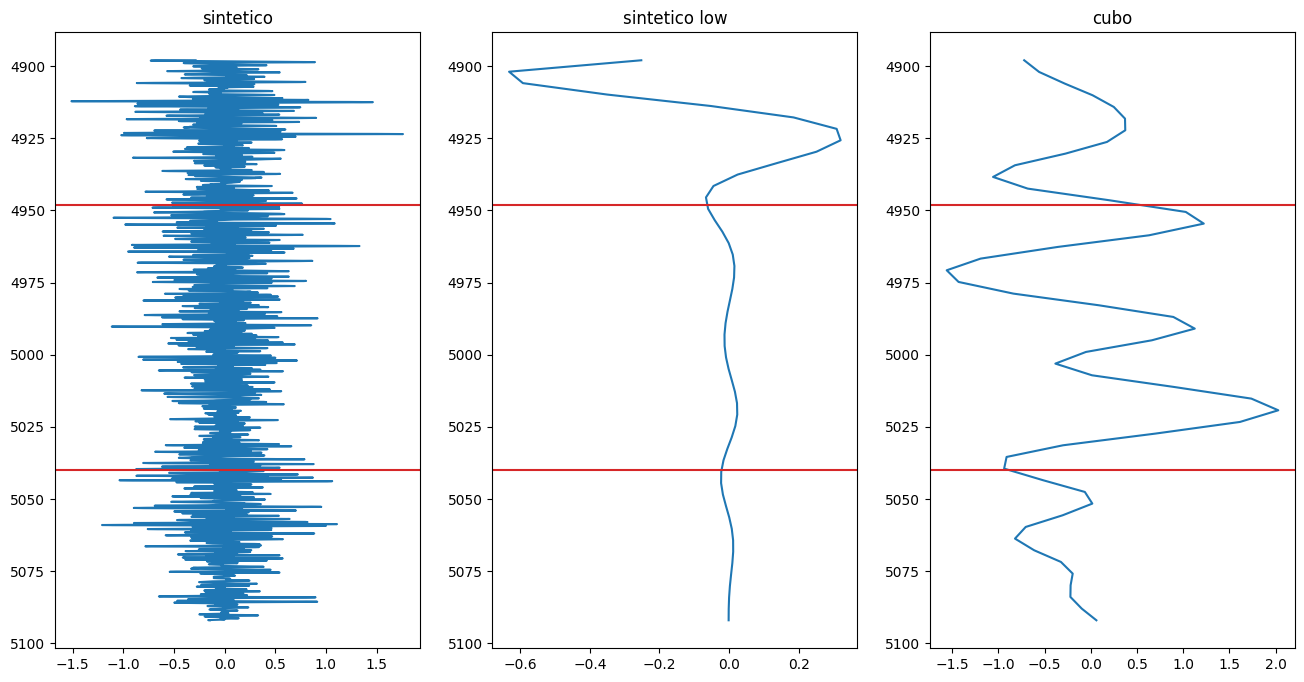

In [27]:
synth5low = np.convolve(wav_100_20_Z_4898_5092, Rpp5low, mode = 'same')

fig, axes = plt.subplots(1, 3, figsize = (16, 8))

zz = np.linspace(depth_point1, depth_point2, len(synth5))
axes[0].plot(synth5, zz);
axes[0].invert_yaxis();
axes[0].set_title('sintetico');
zz = np.linspace(depth_point1, depth_point2, synth5low.shape[0])
axes[1].plot(synth5low, zz);
axes[1].invert_yaxis();
axes[1].set_title('sintetico low');
# axes[1].set_xlim([-0.01, 0.01]);
zz = np.linspace(depth_point1, depth_point2, len(sismica5))
axes[2].plot(sismica5, zz);
axes[2].invert_yaxis();
axes[2].set_title('cubo');

[axes[i].axhline(y = depth_point1true, color = 'tab:red') for i in range(3)];
[axes[i].axhline(y = depth_point2true, color = 'tab:red') for i in range(3)];

### low imp

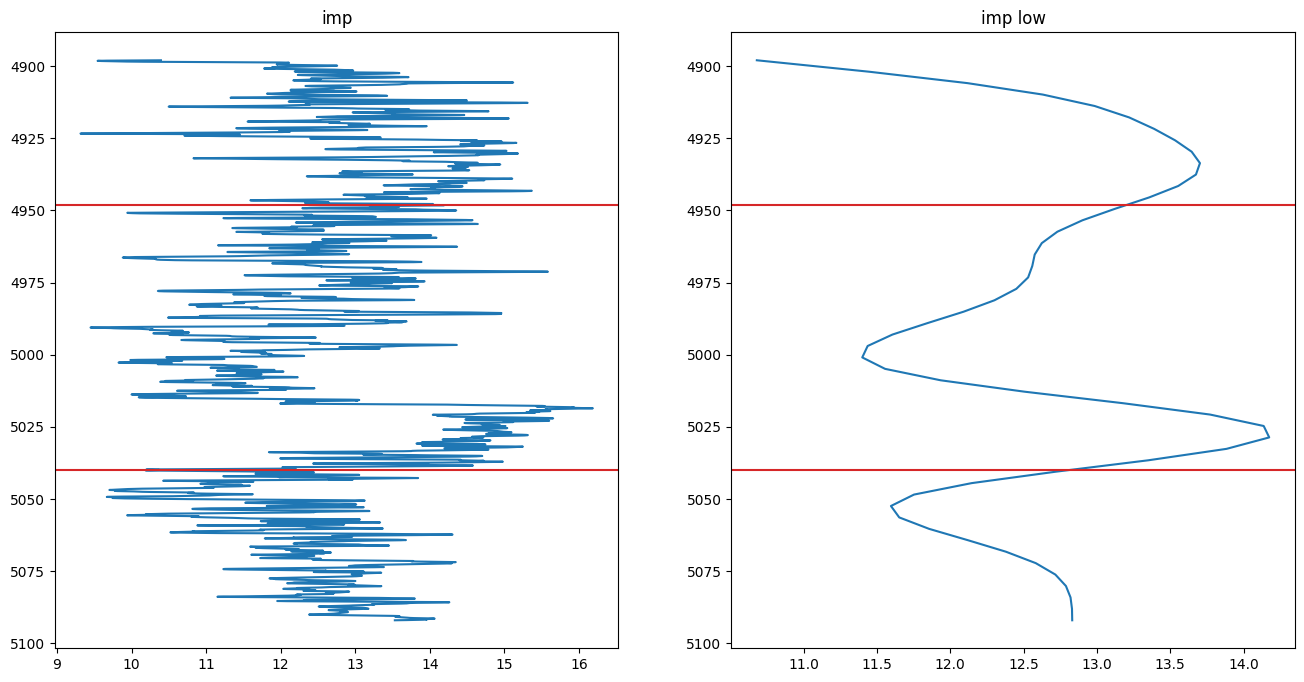

In [28]:
imp5low = escala_sismica(twt5[idx5], imp5, np.array(V3D.data), depth_point1, depth_point2)

fig, axes = plt.subplots(1, 2, figsize = (16, 8))

zz = np.linspace(depth_point1, depth_point2, len(Rpp5))
axes[0].plot(imp5, zz);
axes[0].invert_yaxis();
axes[0].set_title('imp');
zz = np.linspace(depth_point1, depth_point2, synth5low.shape[0])
axes[1].plot(imp5low, zz);
axes[1].invert_yaxis();
axes[1].set_title('imp low');
# axes[1].set_xlim([-0.005, 0.005]);

[axes[i].axhline(y = depth_point1true, color = 'tab:red') for i in range(2)];
[axes[i].axhline(y = depth_point2true, color = 'tab:red') for i in range(2)];

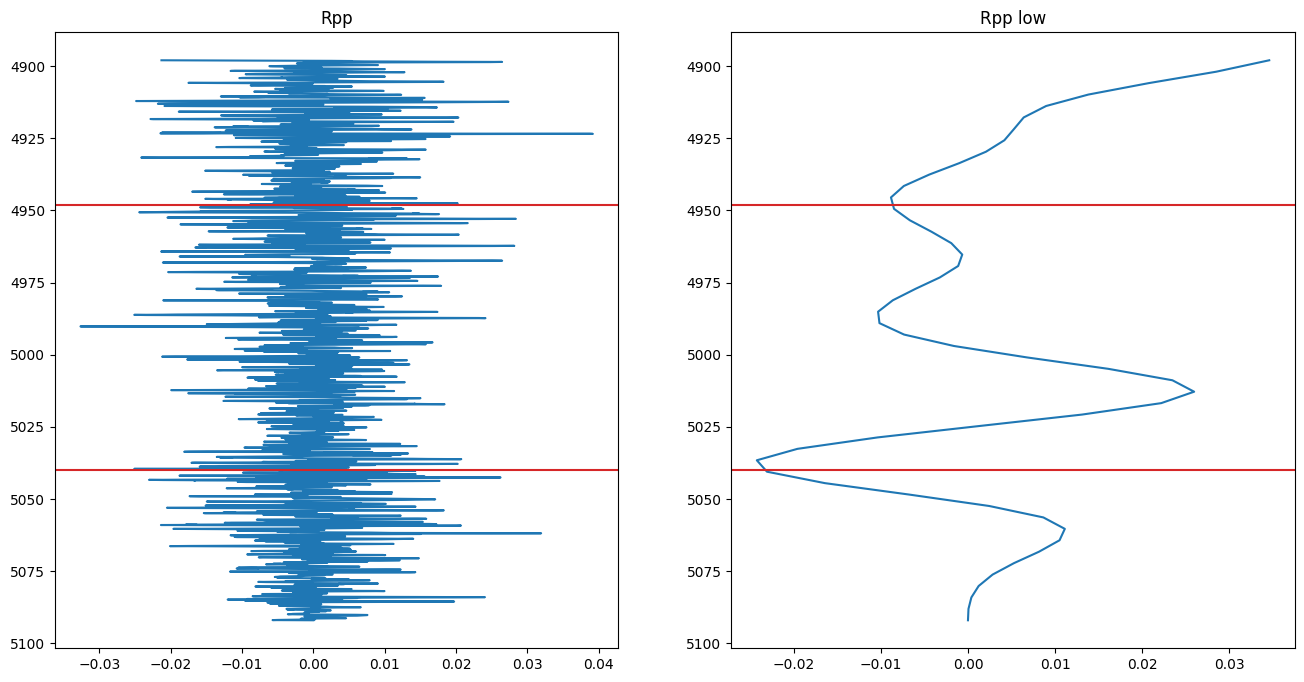

In [29]:
Rpp5low = RC_fwd_model_ia(imp5low[:-1], imp5low[1:])
Rpplast5 = 0.0 / imp5low[0]
Rpp5low = np.concatenate([Rpp5low, np.expand_dims(Rpplast5, axis = 0)], axis = 0)

fig, axes = plt.subplots(1, 2, figsize = (16, 8))

zz = np.linspace(depth_point1, depth_point2, len(Rpp5))
axes[0].plot(Rpp5, zz);
axes[0].invert_yaxis();
axes[0].set_title('Rpp');
zz = np.linspace(depth_point1, depth_point2, synth5low.shape[0])
axes[1].plot(Rpp5low, zz);
axes[1].invert_yaxis();
axes[1].set_title('Rpp low');
# axes[1].set_xlim([-0.005, 0.005]);

[axes[i].axhline(y = depth_point1true, color = 'tab:red') for i in range(2)];
[axes[i].axhline(y = depth_point2true, color = 'tab:red') for i in range(2)];

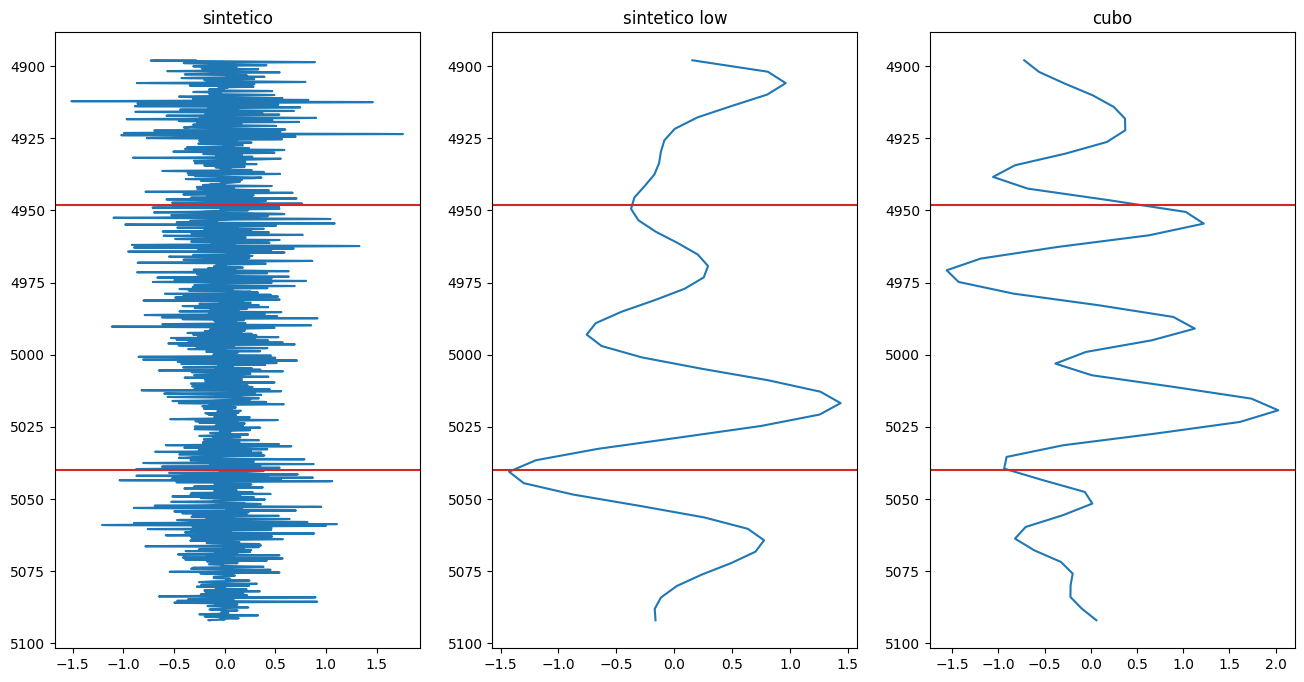

In [30]:
synth5low = np.convolve(wav_100_20_Z_4898_5092, Rpp5low, mode = 'same')

fig, axes = plt.subplots(1, 3, figsize = (16, 8))

zz = np.linspace(depth_point1, depth_point2, len(synth5))
axes[0].plot(synth5, zz);
axes[0].invert_yaxis();
axes[0].set_title('sintetico');
zz = np.linspace(depth_point1, depth_point2, synth5low.shape[0])
axes[1].plot(synth5low, zz);
axes[1].invert_yaxis();
axes[1].set_title('sintetico low');
# axes[1].set_xlim([-0.01, 0.01]);
zz = np.linspace(depth_point1, depth_point2, len(sismica5))
axes[2].plot(sismica5, zz);
axes[2].invert_yaxis();
axes[2].set_title('cubo');

[axes[i].axhline(y = depth_point1true, color = 'tab:red') for i in range(3)];
[axes[i].axhline(y = depth_point2true, color = 'tab:red') for i in range(3)];

### low vp rho

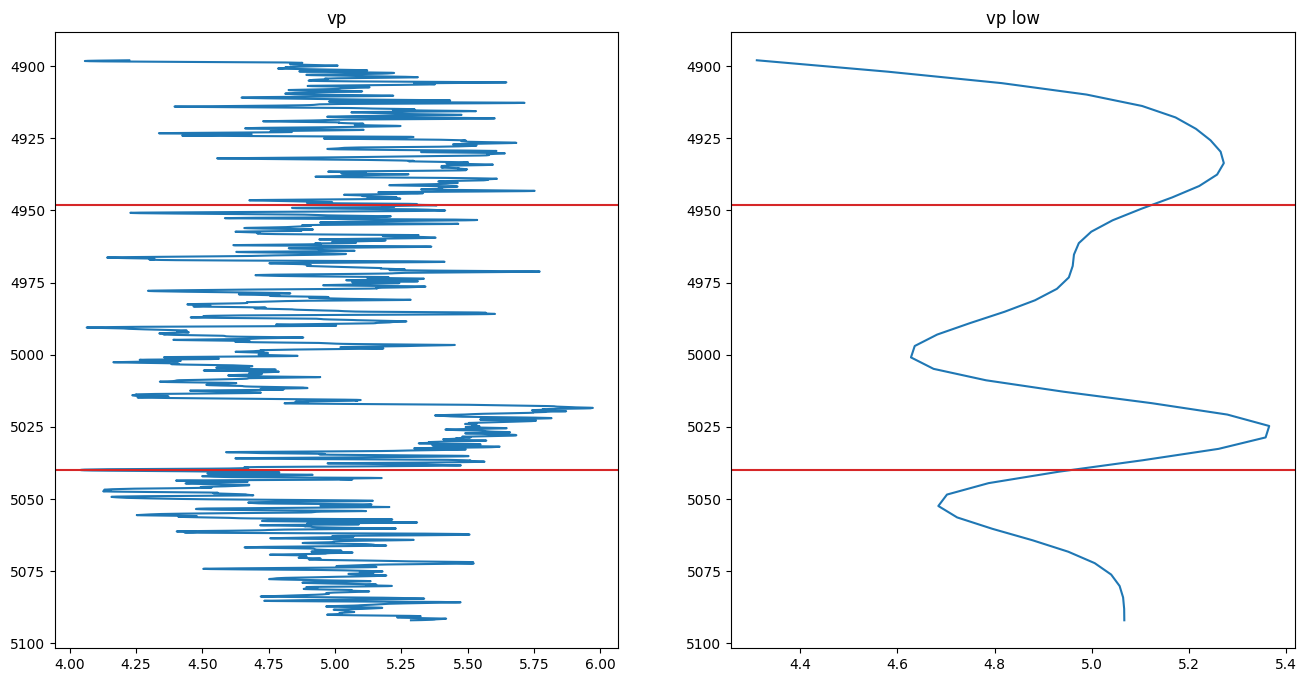

In [31]:
vp5low = escala_sismica(twt5[idx5], vp5[idx5], np.array(V3D.data), depth_point1, depth_point2)

fig, axes = plt.subplots(1, 2, figsize = (16, 8))

zz = np.linspace(depth_point1, depth_point2, len(Rpp5))
axes[0].plot(vp5[idx5], zz);
axes[0].invert_yaxis();
axes[0].set_title('vp');
zz = np.linspace(depth_point1, depth_point2, synth5low.shape[0])
axes[1].plot(vp5low, zz);
axes[1].invert_yaxis();
axes[1].set_title('vp low');
# axes[1].set_xlim([-0.005, 0.005]);

[axes[i].axhline(y = depth_point1true, color = 'tab:red') for i in range(2)];
[axes[i].axhline(y = depth_point2true, color = 'tab:red') for i in range(2)];

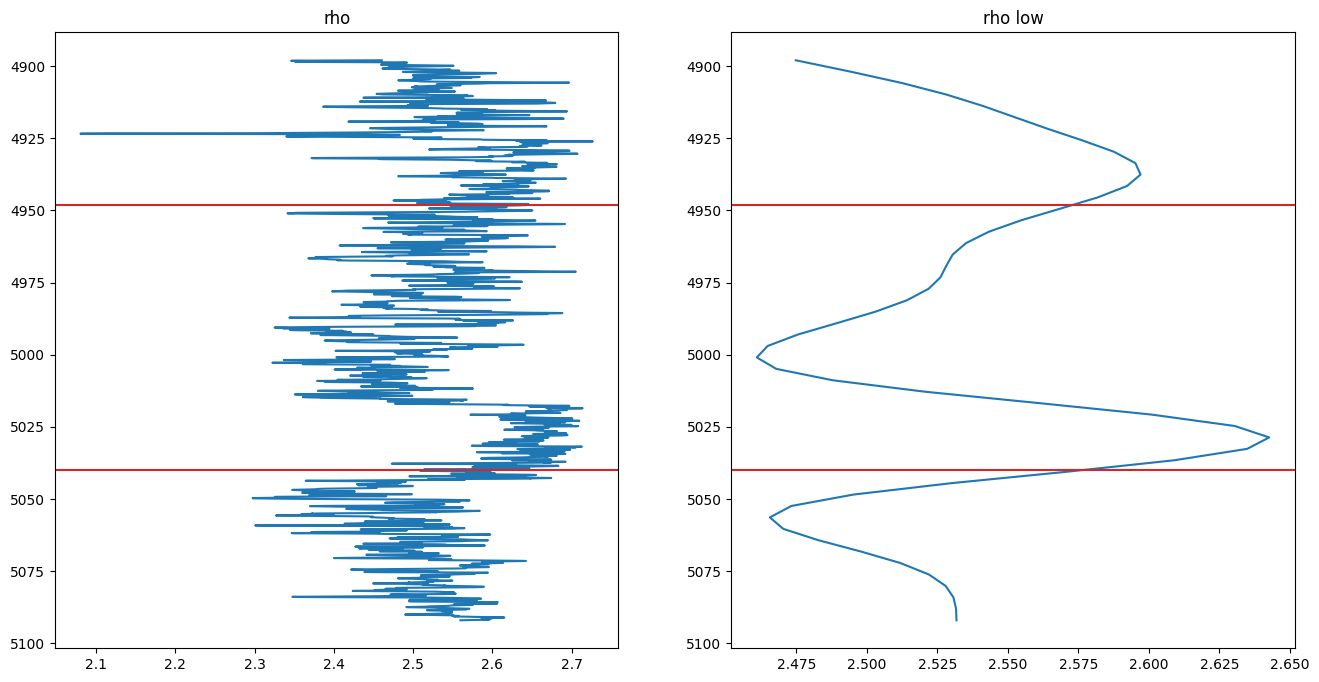

In [32]:
rho5low = escala_sismica(twt5[idx5], rho5[idx5], np.array(V3D.data), depth_point1, depth_point2)

fig, axes = plt.subplots(1, 2, figsize = (16, 8))

zz = np.linspace(depth_point1, depth_point2, len(Rpp5))
axes[0].plot(rho5[idx5], zz);
axes[0].invert_yaxis();
axes[0].set_title('rho');
zz = np.linspace(depth_point1, depth_point2, synth5low.shape[0])
axes[1].plot(rho5low, zz);
axes[1].invert_yaxis();
axes[1].set_title('rho low');
# axes[1].set_xlim([-0.005, 0.005]);

[axes[i].axhline(y = depth_point1true, color = 'tab:red') for i in range(2)];
[axes[i].axhline(y = depth_point2true, color = 'tab:red') for i in range(2)];

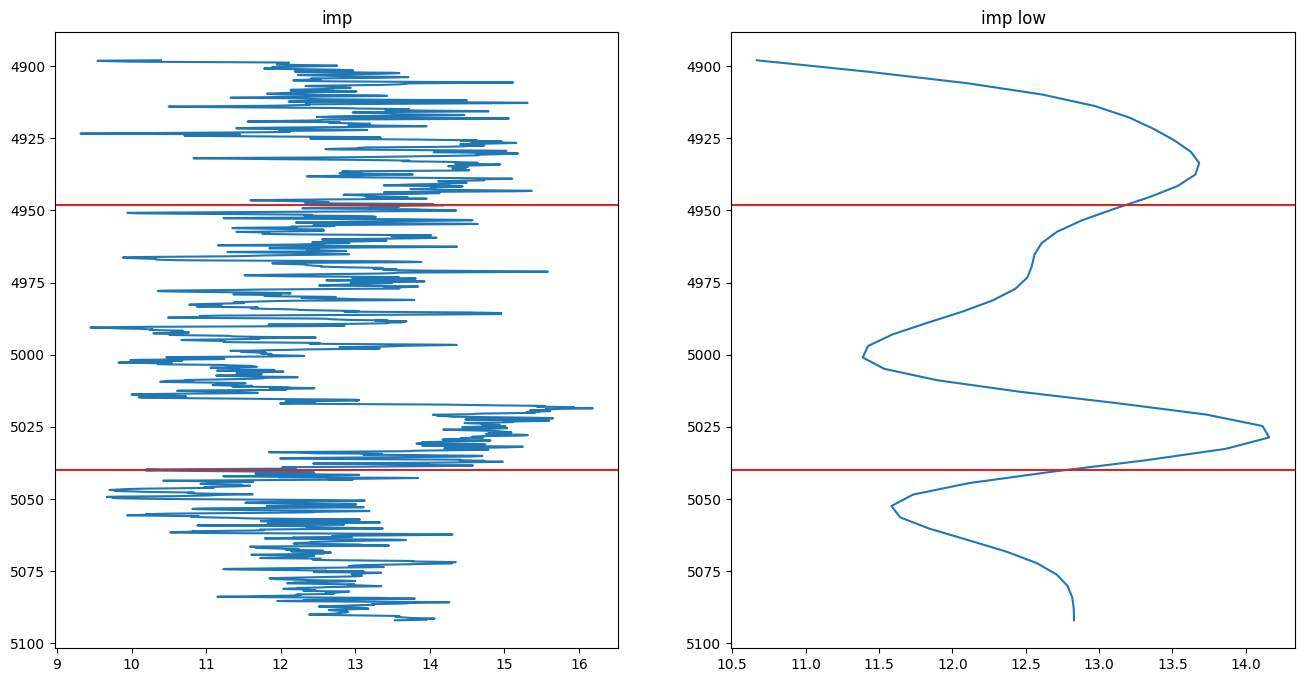

In [33]:
imp5low = vp5low * rho5low

fig, axes = plt.subplots(1, 2, figsize = (16, 8))

zz = np.linspace(depth_point1, depth_point2, len(Rpp5))
axes[0].plot(imp5, zz);
axes[0].invert_yaxis();
axes[0].set_title('imp');
zz = np.linspace(depth_point1, depth_point2, synth5low.shape[0])
axes[1].plot(imp5low, zz);
axes[1].invert_yaxis();
axes[1].set_title('imp low');
# axes[1].set_xlim([-0.005, 0.005]);

[axes[i].axhline(y = depth_point1true, color = 'tab:red') for i in range(2)];
[axes[i].axhline(y = depth_point2true, color = 'tab:red') for i in range(2)];

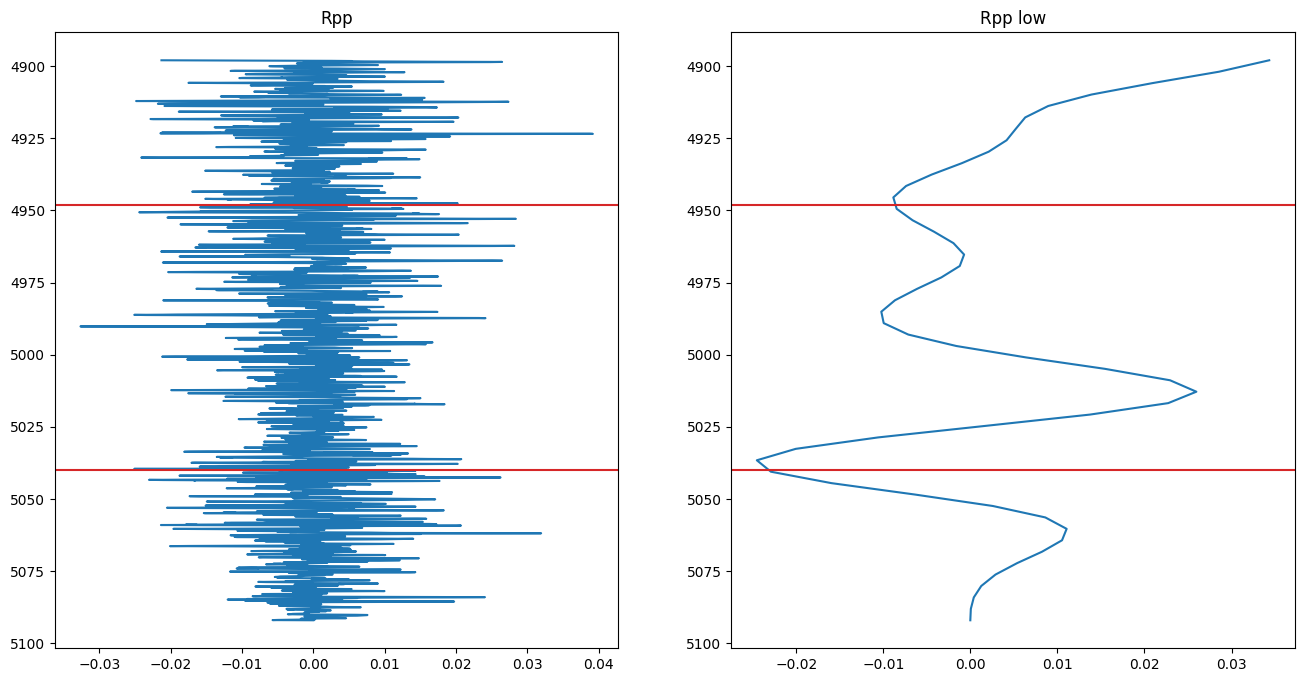

In [34]:
Rpp5low = RC_fwd_model_ia(imp5low[:-1], imp5low[1:])
Rpplast5 = 0.0 / imp5low[0]
Rpp5low = np.concatenate([Rpp5low, np.expand_dims(Rpplast5, axis = 0)], axis = 0)

fig, axes = plt.subplots(1, 2, figsize = (16, 8))

zz = np.linspace(depth_point1, depth_point2, len(Rpp5))
axes[0].plot(Rpp5, zz);
axes[0].invert_yaxis();
axes[0].set_title('Rpp');
zz = np.linspace(depth_point1, depth_point2, synth5low.shape[0])
axes[1].plot(Rpp5low, zz);
axes[1].invert_yaxis();
axes[1].set_title('Rpp low');
# axes[1].set_xlim([-0.005, 0.005]);

[axes[i].axhline(y = depth_point1true, color = 'tab:red') for i in range(2)];
[axes[i].axhline(y = depth_point2true, color = 'tab:red') for i in range(2)];

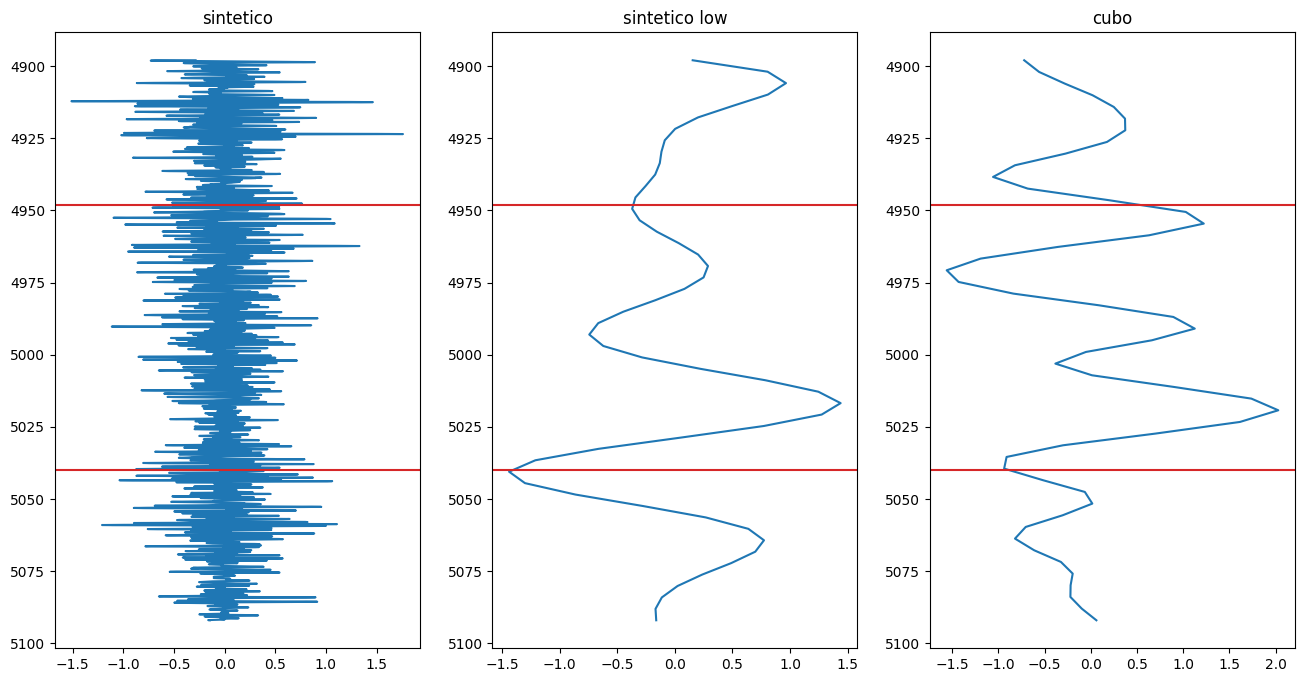

In [35]:
synth5low = np.convolve(wav_100_20_Z_4898_5092, Rpp5low, mode = 'same')

fig, axes = plt.subplots(1, 3, figsize = (16, 8))

zz = np.linspace(depth_point1, depth_point2, len(synth5))
axes[0].plot(synth5, zz);
axes[0].invert_yaxis();
axes[0].set_title('sintetico');
zz = np.linspace(depth_point1, depth_point2, synth5low.shape[0])
axes[1].plot(synth5low, zz);
axes[1].invert_yaxis();
axes[1].set_title('sintetico low');
# axes[1].set_xlim([-0.01, 0.01]);
zz = np.linspace(depth_point1, depth_point2, len(sismica5))
axes[2].plot(sismica5, zz);
axes[2].invert_yaxis();
axes[2].set_title('cubo');

[axes[i].axhline(y = depth_point1true, color = 'tab:red') for i in range(3)];
[axes[i].axhline(y = depth_point2true, color = 'tab:red') for i in range(3)];